In [1]:
import Transformer as T
import Helpers as H
import torch
from torch import nn
from d2l import torch as d2l
from glob import glob
import pandas as pd
import numpy as np

In [2]:
## get dataloaders, train, test, valid
csv_files_path = glob("data/*.csv")

df_list = []
count_samples = 0
for filename in csv_files_path:
    print(filename, len(pd.read_csv(filename, header=None, dtype=float)))
    count_samples += len(pd.read_csv(filename, header=None))
    df_list.append(pd.read_csv(filename, header=None))

dataset_df = pd.concat(df_list, axis=0)
print("Total number of samples:", count_samples)

data/Template_3.csv 8423
data/Template_12.csv 272
data/Template_13.csv 4052
data/Template_2.csv 12488
data/Template_0.csv 2097
data/Template_11.csv 276
data/Template_10.csv 272
data/Template_1.csv 4892
data/Template_5.csv 10748
data/Template_14.csv 272
data/Template_15.csv 512
data/Template_4.csv 245
data/Template_6.csv 269
data/Template_17.csv 11369
data/Template_16.csv 3737
data/Template_7.csv 4598
data/Template_9.csv 4544
data/Template_8.csv 269
Total number of samples: 69335


In [3]:
dataset_df.fillna(value=0, inplace=True)
dataset_df[0] = dataset_df[0].astype(int)
dataset_df = dataset_df.iloc[:,:-1]
dataset_np = dataset_df.to_numpy()
dataset_np.shape, dataset_df.shape
X, y = dataset_np[:, 1:], dataset_np[:, 0]
y.shape

(69335,)

In [4]:
dataset = H.SeismicData(X, y, test_size=0.2, val_size=0.2, batch_size=32)

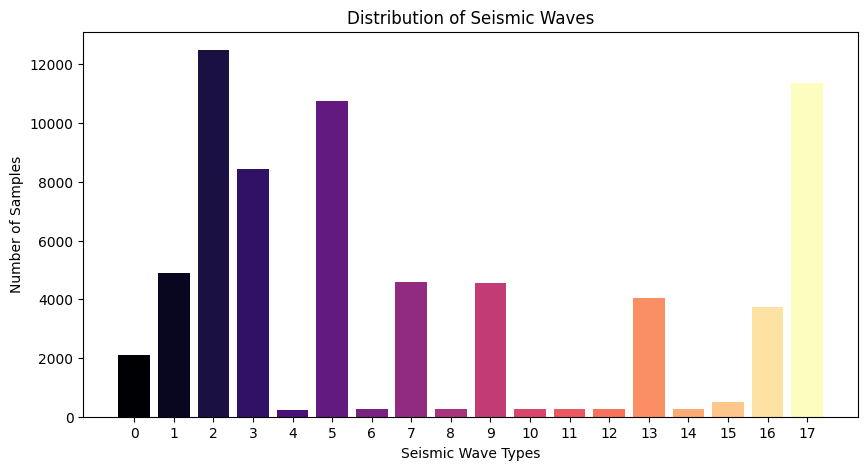

In [5]:
class_names, counts = np.unique(dataset.y, return_counts=True)
H.explore.display_class_distribution(class_names, counts)

In [6]:
# create dataloaders
train_dataloader = dataset.get_dataloader('train')
test_dataloader = dataset.get_dataloader('test')
val_dataloader = dataset.get_dataloader('val')

In [7]:
## define model

# hyperparams
num_hiddens, num_heads = 128, 16
batch_size, num_queries, num_kvpairs = 2, 4, 6

attention = T.MultiHeadAttention(num_hiddens, num_heads, 0.5)
# AND if you have a past iteration of training...
#attention.load_state_dict(torch.load(f'model_weights_epochs{1}-{10}.pth'))

/opt/anaconda3/envs/general_ml/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
## define optimizer and loss and embedding dim

optimizer = torch.optim.AdamW(attention.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

embedding_dim = num_hiddens  # e.g., 128, 256, 512, etc.
input_projection = nn.Linear(1, embedding_dim)  # Projects each token to embedding_dim

In [ ]:
## train for n epochs, then save model params

epochs = 10
loss_train = []
loss_valid = []
accuracy_valid = []

for i in range(epochs):
    print(f'Epoch {i+1}')

    #train
    attention.train()
    loss_vals = []
    for batch_idx, (batch_X, batch_y) in enumerate(train_dataloader):# load data from dataloader
        optimizer.zero_grad()
        batch_X = batch_X.unsqueeze(-1)
        embedded_X = input_projection(batch_X)
        query = embedded_X # (sequence_length, batch_size, embed_dim)
        key = embedded_X
        value = embedded_X
        preds = attention.forward(queries=query, keys=key, values=value, valid_lens=None )
        loss = loss_fn(preds, batch_y)
        loss_vals.append(loss.item())
        loss.backward()
        optimizer.step()
    loss_train.append(np.mean(loss_vals))

     # validate
    attention.eval()
    loss_vals = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (batch_X, batch_y) in enumerate(test_dataloader):#data_test.get_dataloader():
            batch_X = batch_X.unsqueeze(-1)
            embedded_X = input_projection(batch_X)
            query = embedded_X # (sequence_length, batch_size, embed_dim)
            key = embedded_X
            value = embedded_X
            preds = attention.forward(queries=query, keys=key, values=value, valid_lens=None )
            loss = loss_fn(preds, batch_y)
            loss_vals.append(loss.item())

            # calculate accuracy
            correct += (preds.argmax(dim=1) == batch_y).sum().item()
            total += batch_y.size(0)
    loss_valid.append(np.mean(loss_vals))
    accuracy = correct / total
    accuracy_valid.append(accuracy)
    print(f'        accuracy: {accuracy:.4f}')

Epoch 1


In [ ]:
## now save this version of the model

torch.save(attention.state_dict(), f'model_weights_epochs{1}-{10}.pth')

In [ ]:
## or, to load in the previous model

